In [1]:
# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime
from datetime import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.tools.eval_measures as      em
from   sklearn.metrics                 import  mean_squared_error
from   statsmodels.tsa.api             import ExponentialSmoothing, SimpleExpSmoothing, Holt


# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")
from   IPython.display                 import display
from   pylab                           import rcParams
plt.rcParams['figure.figsize'] = [7, 5]

C:\Users\lavan\AppData\Local\Temp\ipykernel_31808\2062769088.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Read the data

In [2]:
df = pd.read_csv(r"C:\Users\lavan\Downloads\Sparkling.csv")

In [3]:
#Check data types
df.dtypes

YearMonth    object
Sparkling     int64
dtype: object

In [4]:
#We are providing inputs to tell pandas that we are trying to work with time series.
df = pd.read_csv(r"C:\Users\lavan\Downloads\Rose.csv", parse_dates = ['YearMonth'])



In [5]:
#Check data types
df.dtypes

YearMonth    datetime64[ns]
Rose                float64
dtype: object

In [6]:
#It is recommended that we make our time series reference as the index
df = pd.read_csv(r"C:\Users\lavan\Downloads\Sparkling.csv", parse_dates = ['YearMonth'], index_col = 'YearMonth')

In [7]:
df.head()

,Sparkling
YearMonth,
1980-01-01,1686
1980-02-01,1591
1980-03-01,2304
1980-04-01,1712
1980-05-01,1471


## Exploratory Data Analysis

In [8]:
print("The number of rows: ",df.shape[0], "\n""The number of columns: ",df.shape[1])

The number of rows:  187 
The number of columns:  1


In [162]:
df.dtypes

Sparkling    int64
dtype: object

In [9]:
# Check the frequency of the time series
frequency = pd.infer_freq(df.index)

# Print the frequency
print("Time Series Frequency:", frequency)


Time Series Frequency: MS


In [10]:
total_missing_values = df.isna().sum()
print("Total Missing Values:")
print(total_missing_values)


Total Missing Values:
Sparkling    0
dtype: int64


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sparkling  187 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


In [12]:
round(df.describe(),3)

,Sparkling
count,187.000
mean,2402.417
std,1295.112
min,1070.000
25%,1605.000
50%,1874.000
75%,2549.000
max,7242.000


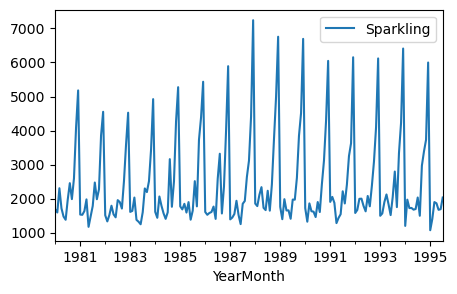

In [13]:
#Increase the figure size
from pylab import rcParams
rcParams['figure.figsize'] = 5, 3
df.plot()
plt.show()

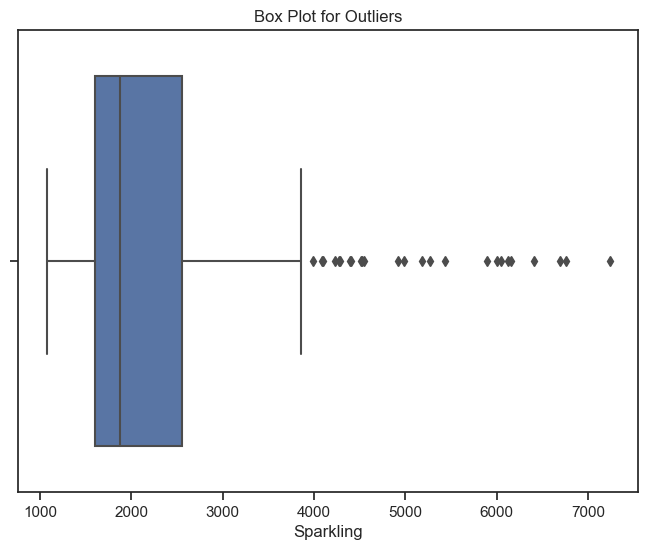

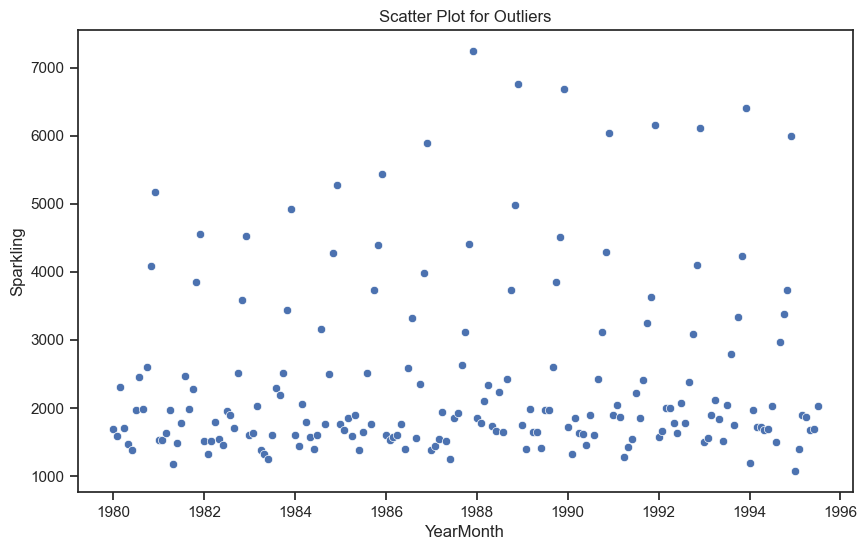

Outliers:
            Sparkling
YearMonth            
1987-12-01       7242
1988-12-01       6757
1989-12-01       6694
1993-12-01       6410


In [145]:
# Box plot to identify outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Sparkling'])
plt.title('Box Plot for Outliers')
plt.show()

# Scatter plot for visualizing outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y='Sparkling', data=df)
plt.title('Scatter Plot for Outliers')
plt.show()

# Z-score to identify outliers
from scipy.stats import zscore

z_scores = zscore(df['Sparkling'])
outliers = (z_scores > 3) | (z_scores < -3)
outliers_df = df[outliers]
print('Outliers:')
print(outliers_df)


The provided data indicates outliers in the 'Sparkling' variable for specific months. Here are insights :

1. Outlier Identification:
   - Outliers in the 'Sparkling' variable are observed in December of the years 1987, 1988, 1989, and 1993.
   
2. Potential Seasonal Pattern:
   - The recurring outliers in December suggest a potential seasonal pattern or anomaly in the 'Sparkling' variable during those years.

3. Further Investigation:
   - Further investigation and analysis are recommended to understand the underlying factors contributing to the outliers and to determine if they represent a consistent pattern or specific events in those particular December months.

## Empirical Cumulative Distribution Function

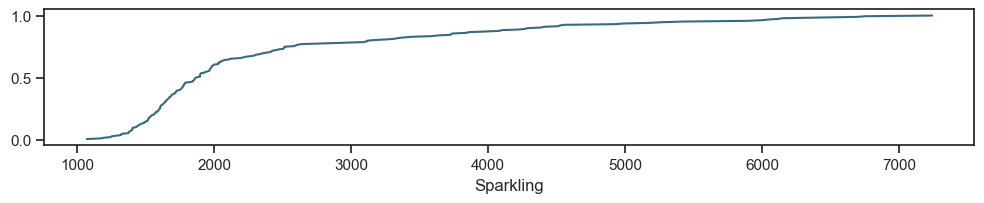

In [14]:
# Plot ECDF: Empirical Cumulative Distribution Function
#ECDF - Adds up the number of observations that are there for a certain value.
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

  
plt.subplot(312)
cdf = ECDF(df['Sparkling'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Sparkling');

## Yearly and Monthly Boxplots

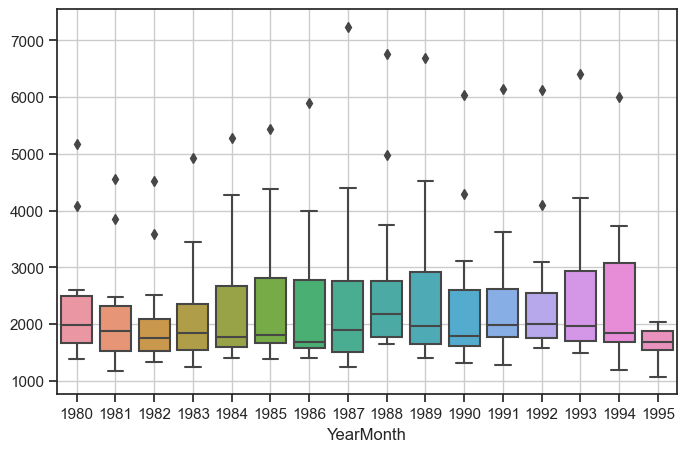

In [15]:
_, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x = df.index.year,y = df.values[:,0],ax=ax)
plt.grid();

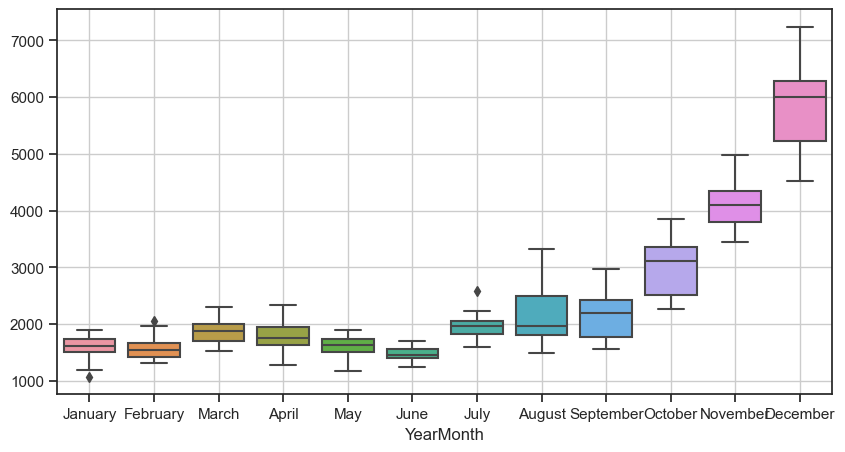

In [16]:
_, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x = df.index.month_name(),y = df.values[:,0],ax=ax)
plt.grid();

## Monthly plot

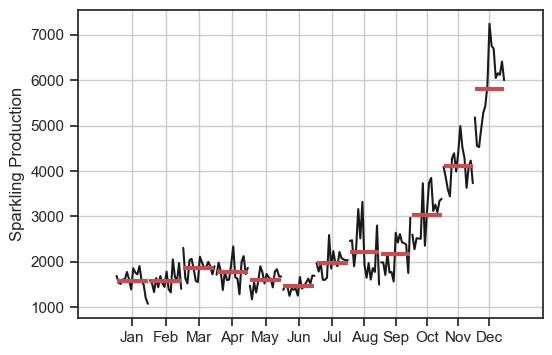

In [17]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(6,4))

month_plot(df,ylabel='Sparkling Production',ax=ax)
plt.grid();

 *Performing the decomposition of data as there is an existence of seasonality and splitting the data accordingly.* Observing how number of wine sold vary on a month on month basis. A stacked plot for every year will give us a clear pattern of any seasonality over the many years and those changes will be clearly reflected in the plots.

In [18]:
yearly_sales_across_months = pd.pivot_table(df, values = 'Sparkling', columns = df.index.month, 
                                        index = df.index.year)

yearly_sales_across_months

YearMonth,1,2,3,4,5,6,7,8,9,10,11,12
YearMonth,,,,,,,,,,,,
1980,1686.0,1591.0,2304.0,1712.0,1471.0,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0,5179.0
1981,1530.0,1523.0,1633.0,1976.0,1170.0,1480.0,1781.0,2472.0,1981.0,2273.0,3857.0,4551.0
1982,1510.0,1329.0,1518.0,1790.0,1537.0,1449.0,1954.0,1897.0,1706.0,2514.0,3593.0,4524.0
1983,1609.0,1638.0,2030.0,1375.0,1320.0,1245.0,1600.0,2298.0,2191.0,2511.0,3440.0,4923.0
1984,1609.0,1435.0,2061.0,1789.0,1567.0,1404.0,1597.0,3159.0,1759.0,2504.0,4273.0,5274.0
1985,1771.0,1682.0,1846.0,1589.0,1896.0,1379.0,1645.0,2512.0,1771.0,3727.0,4388.0,5434.0
1986,1606.0,1523.0,1577.0,1605.0,1765.0,1403.0,2584.0,3318.0,1562.0,2349.0,3987.0,5891.0
1987,1389.0,1442.0,1548.0,1935.0,1518.0,1250.0,1847.0,1930.0,2638.0,3114.0,4405.0,7242.0
1988,1853.0,1779.0,2108.0,2336.0,1728.0,1661.0,2230.0,1645.0,2421.0,3740.0,4988.0,6757.0


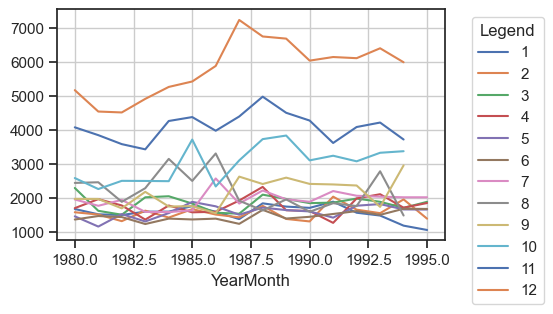

In [19]:
fig, ax = plt.subplots(figsize=(5,3))
yearly_sales_across_months.plot(ax=ax)
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')


<Axes: >

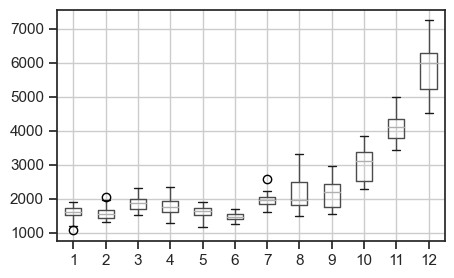

In [147]:
yearly_sales_across_months.boxplot()

In [20]:
monthly_sales_across_months = pd.pivot_table(df, values='Sparkling', columns=df.index.year, index=df.index.month)
monthly_sales_across_months


YearMonth,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995
YearMonth,,,,,,,,,,,,,,,,
1,1686.0,1530.0,1510.0,1609.0,1609.0,1771.0,1606.0,1389.0,1853.0,1757.0,1720.0,1902.0,1577.0,1494.0,1197.0,1070.0
2,1591.0,1523.0,1329.0,1638.0,1435.0,1682.0,1523.0,1442.0,1779.0,1394.0,1321.0,2049.0,1667.0,1564.0,1968.0,1402.0
3,2304.0,1633.0,1518.0,2030.0,2061.0,1846.0,1577.0,1548.0,2108.0,1982.0,1859.0,1874.0,1993.0,1898.0,1720.0,1897.0
4,1712.0,1976.0,1790.0,1375.0,1789.0,1589.0,1605.0,1935.0,2336.0,1650.0,1628.0,1279.0,1997.0,2121.0,1725.0,1862.0
5,1471.0,1170.0,1537.0,1320.0,1567.0,1896.0,1765.0,1518.0,1728.0,1654.0,1615.0,1432.0,1783.0,1831.0,1674.0,1670.0
6,1377.0,1480.0,1449.0,1245.0,1404.0,1379.0,1403.0,1250.0,1661.0,1406.0,1457.0,1540.0,1625.0,1515.0,1693.0,1688.0
7,1966.0,1781.0,1954.0,1600.0,1597.0,1645.0,2584.0,1847.0,2230.0,1971.0,1899.0,2214.0,2076.0,2048.0,2031.0,2031.0
8,2453.0,2472.0,1897.0,2298.0,3159.0,2512.0,3318.0,1930.0,1645.0,1968.0,1605.0,1857.0,1773.0,2795.0,1495.0,NaN
9,1984.0,1981.0,1706.0,2191.0,1759.0,1771.0,1562.0,2638.0,2421.0,2608.0,2424.0,2408.0,2377.0,1749.0,2968.0,NaN


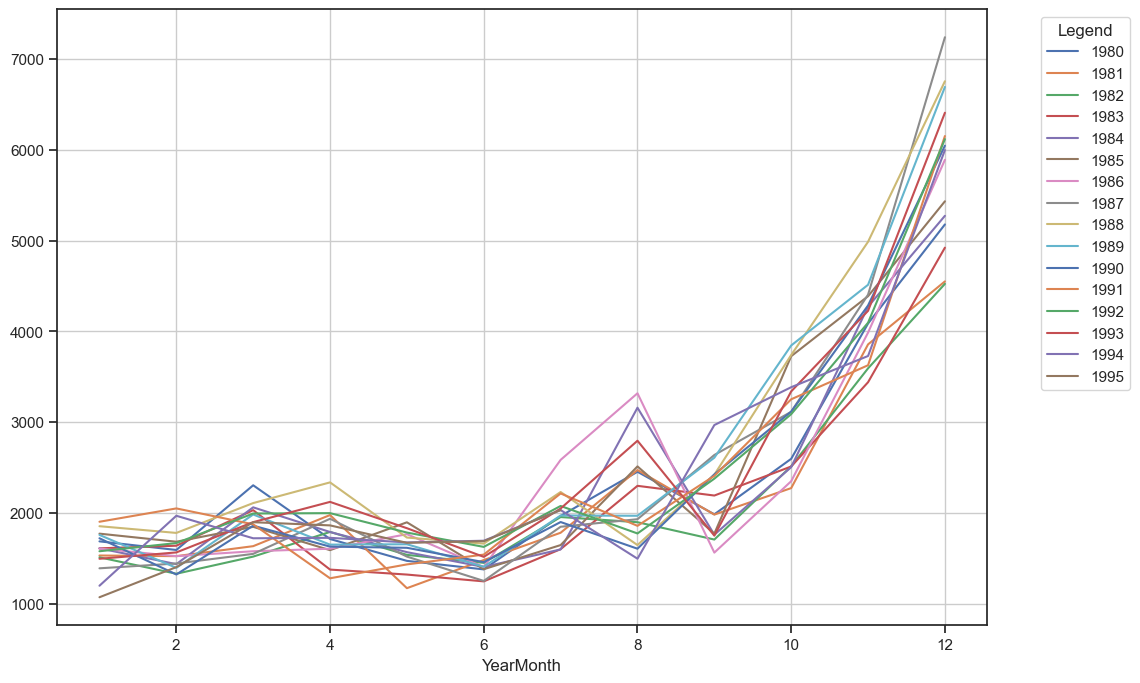

In [21]:
monthly_sales_across_months.plot(figsize=(12, 8))
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')


## Downsampling

Resampling to a "coarser time resolution than monthly" involves aggregating the original monthly data into quarterly and yearly intervals, providing a less detailed but broader overview of trends. This transformation simplifies the data, facilitating the identification of longer-term patterns and reducing noise for certain analytical purposes. The resulting dataset now contains averaged values for every quarter instead of individual monthly data points.

In [22]:
#Let's change the monthly series to quarterly. This would require aggregation.
df_q = df.resample('Q').mean()
df_q.head()

,Sparkling
YearMonth,
1980-03-31,1860.333333
1980-06-30,1520.000000
1980-09-30,2134.333333
1980-12-31,3954.000000
1981-03-31,1562.000000


<Axes: xlabel='YearMonth'>

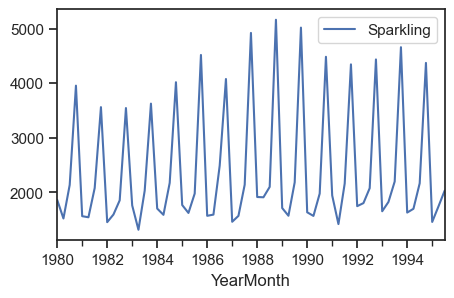

In [23]:
df_q.plot(figsize=(5, 3))

In [24]:
df_yearly_sum = df.resample('A').sum()
df_yearly_sum.head()

,Sparkling
YearMonth,
1980-12-31,28406
1981-12-31,26227
1982-12-31,25321
1983-12-31,26180
1984-12-31,28431


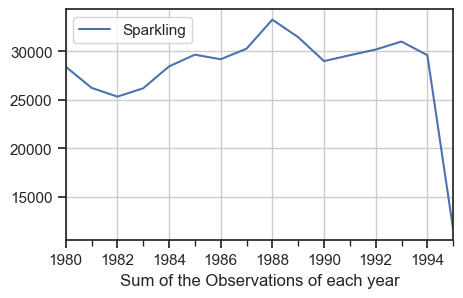

In [25]:
df_yearly_sum.plot();
plt.grid()
plt.xlabel('Sum of the Observations of each year');

# Upsampling

In [26]:
#Let's change the monthly series to daily. 
df1_d = df.resample('D').ffill()
df1_d.head()


,Sparkling
YearMonth,
1980-01-01,1686
1980-01-02,1686
1980-01-03,1686
1980-01-04,1686
1980-01-05,1686


<Axes: xlabel='YearMonth'>

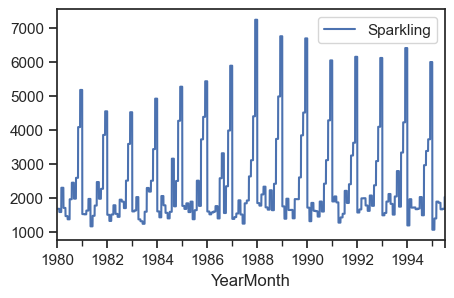

In [27]:
df1_d.plot()

## Decomposition

In [30]:
#Decompose the time series additively
df_add_decompose = seasonal_decompose(df, model = 'additive', period = 12)

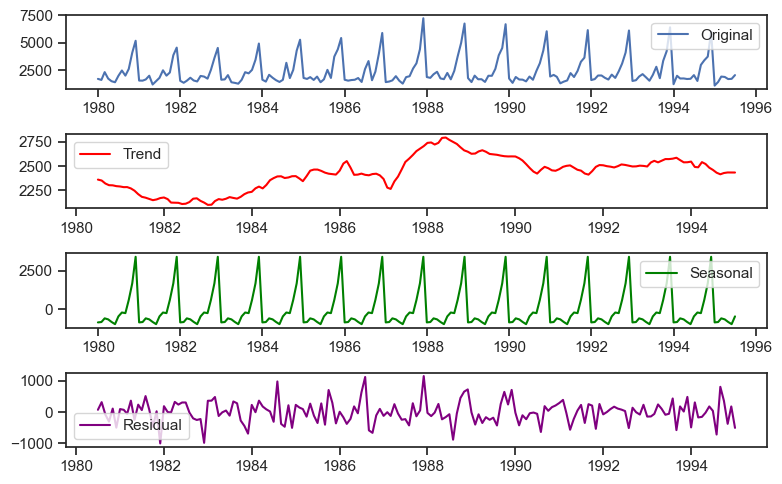

In [31]:
plt.figure(figsize=(8, 5))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(df.index, df, label='Original')
plt.legend()

# Trend component
plt.subplot(4, 1, 2)
plt.plot(df_add_decompose.trend, label='Trend', color='red')
plt.legend()

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(df_add_decompose.seasonal, label='Seasonal', color='green')
plt.legend()

# Residual component
plt.subplot(4, 1, 4)
plt.plot(df_add_decompose.resid, label='Residual', color='purple')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
#Decompose the time series multiplicative
df_mul_decompose = seasonal_decompose(df, model = 'multiplicative', period = 12)

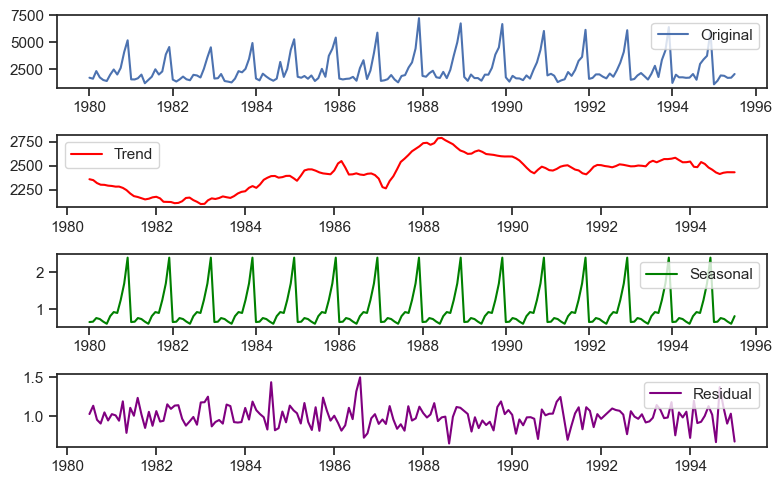

In [33]:
plt.figure(figsize=(8, 5))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(df.index, df, label='Original')
plt.legend()

# Trend component
plt.subplot(4, 1, 2)
plt.plot(df_mul_decompose.trend, label='Trend', color='red')
plt.legend()

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(df_mul_decompose.seasonal, label='Seasonal', color='green')
plt.legend()

# Residual component
plt.subplot(4, 1, 4)
plt.plot(df_mul_decompose.resid, label='Residual', color='purple')
plt.legend()

plt.tight_layout()
plt.show()


Some of our key observations from this analysis:
Trend: 12-months MA is indicating a non linear trend with more complex pattern that doesn't follow a straight line.

Seasonality: seasonality of 12 months is clearly visible

Irregular Remainder (random): The multiplicative not model working as there are  patterns in the residuals

In [34]:
#Let's try to do log transformation
df_log = df.copy()

In [35]:
df_log['Sparkling'] = np.log(df)

In [36]:
df_log.Sparkling

YearMonth
1980-01-01    7.430114
1980-02-01    7.372118
1980-03-01    7.742402
1980-04-01    7.445418
1980-05-01    7.293698
                ...   
1995-03-01    7.548029
1995-04-01    7.529406
1995-05-01    7.420579
1995-06-01    7.431300
1995-07-01    7.616284
Name: Sparkling, Length: 187, dtype: float64

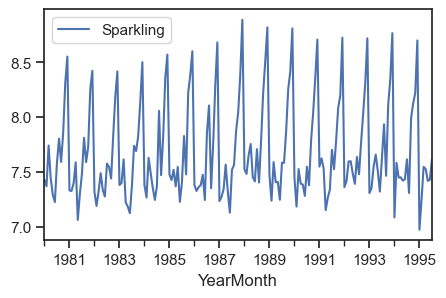

In [37]:
#Visualize the log transformed series
df_log.plot()
plt.show()


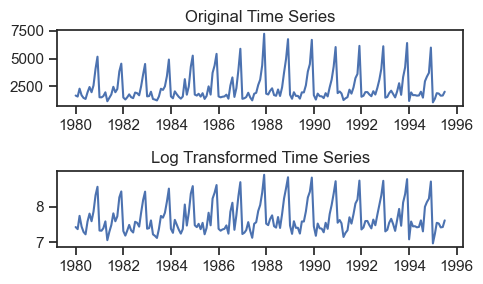

In [38]:
#Compare with the original series
plt.subplot(2,1,1)
plt.title('Original Time Series')
plt.plot(df)

plt.subplot(2,1,2)
plt.title('Log Transformed Time Series')
plt.plot(df_log)
plt.tight_layout()

## Q.3 Split the data into training and test. The test data should start in 1991.

In [39]:
train = df[df.index<'1991'] 
test = df[df.index>='1991']

In [40]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


In [41]:
print('First few rows of Training Data','\n',train.head(),'\n')
print('Last few rows of Training Data','\n',train.tail(),'\n')
print('First few rows of Test Data','\n',test.head(),'\n')
print('Last few rows of Test Data','\n',test.tail(),'\n')

First few rows of Training Data 
             Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471 

Last few rows of Training Data 
             Sparkling
YearMonth            
1990-08-01       1605
1990-09-01       2424
1990-10-01       3116
1990-11-01       4286
1990-12-01       6047 

First few rows of Test Data 
             Sparkling
YearMonth            
1991-01-01       1902
1991-02-01       2049
1991-03-01       1874
1991-04-01       1279
1991-05-01       1432 

Last few rows of Test Data 
             Sparkling
YearMonth            
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031 



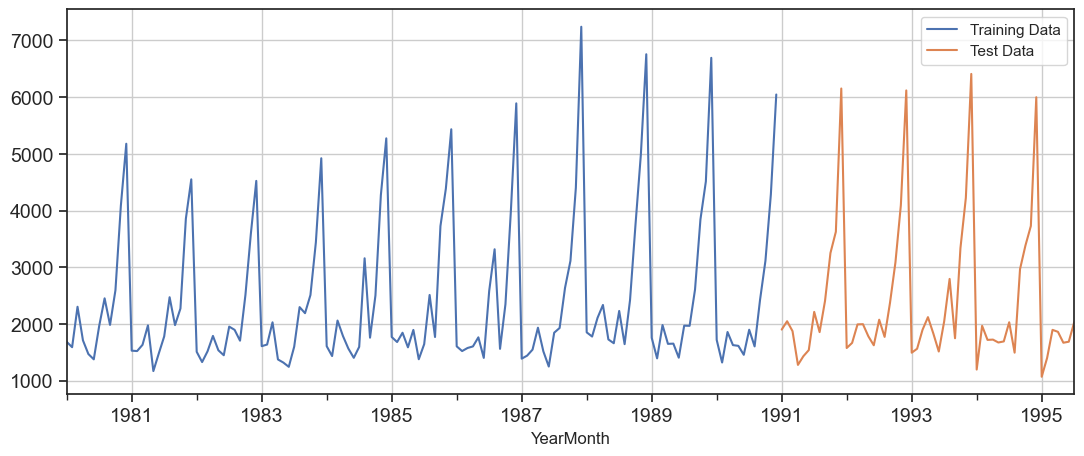

In [42]:
train['Sparkling'].plot(figsize=(13,5), fontsize=14)
test['Sparkling'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

## Q.4 Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other additional models such as regression, naïve forecast models, simple average models, moving average models should also be built on the training data and check the performance on the test data using RMSE.

### SES -  ETS(A, N, N) - Simple Exponential Smoothing with additive errors
###### The simplest of the exponentially smoothing methods is naturally called simple exponential smoothing (SES). 
###### This method is suitable for forecasting data with no clear trend or seasonal pattern.
In Single ES, the forecast at time (t + 1) is given by Winters,1960

* $F_{t+1} = \alpha Y_t + (1-\alpha) F_t$

Parameter $\alpha$ is called the smoothing constant and its value lies between 0 and 1.
Since the model uses only one smoothing constant, it is called Single Exponential Smoothing.



*SimpleExpSmoothing* class must be instantiated and passed the training data. 

The fit() function is then called providing the fit configuration, the alpha value, smoothing_level. 
If this is omitted or set to None, the model will automatically optimize the value.

**Double Exponential Smoothing uses two equations to forecast future values of the time series, one for forecating the short term avarage value or level and the other for capturing the trend.**

* Intercept or Level equation, $L_t$ is given by:
$L_t = {\alpha}{Y_t}  + (1 - \alpha)F_t$ 

* Trend equation is given by 
$T_t = {\beta}{(L_t - L_{t-1})}  + (1 - \beta)T_{t-1}$ 

Here, $\alpha$ and $\beta$ are the smoothing constants for level and trend, respectively, 
* 0 <$\alpha$ < 1 and 0 < $\beta$ < 1.

The forecast at time t + 1 is given by
* $F_{t+1} = L_t + T_t$
* $F_{t+n} = L_t + nT_t$

In [43]:
SES_train = train.copy()
SES_test = test.copy()

In [44]:
# create class
model_SES = SimpleExpSmoothing(SES_train,initialization_method='estimated')

In [45]:
# Fitting the Simple Exponential Smoothing model and asking python to choose the optimal parameters
model_SES_autofit = model_SES.fit(optimized=True)

In [46]:
## Let us check the parameters

model_SES_autofit.params

{'smoothing_level': 0.07029120765764557,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1764.0137060346985,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [47]:
# Using the fitted model on the training set to forecast on the test set
SES_predict = model_SES_autofit.forecast(steps=len(SES_test))
SES_predict

1991-01-01    2804.675124
1991-02-01    2804.675124
1991-03-01    2804.675124
1991-04-01    2804.675124
1991-05-01    2804.675124
1991-06-01    2804.675124
1991-07-01    2804.675124
1991-08-01    2804.675124
1991-09-01    2804.675124
1991-10-01    2804.675124
1991-11-01    2804.675124
1991-12-01    2804.675124
1992-01-01    2804.675124
1992-02-01    2804.675124
1992-03-01    2804.675124
1992-04-01    2804.675124
1992-05-01    2804.675124
1992-06-01    2804.675124
1992-07-01    2804.675124
1992-08-01    2804.675124
1992-09-01    2804.675124
1992-10-01    2804.675124
1992-11-01    2804.675124
1992-12-01    2804.675124
1993-01-01    2804.675124
1993-02-01    2804.675124
1993-03-01    2804.675124
1993-04-01    2804.675124
1993-05-01    2804.675124
1993-06-01    2804.675124
1993-07-01    2804.675124
1993-08-01    2804.675124
1993-09-01    2804.675124
1993-10-01    2804.675124
1993-11-01    2804.675124
1993-12-01    2804.675124
1994-01-01    2804.675124
1994-02-01    2804.675124
1994-03-01  

Text(0.5, 1.0, 'Alpha = 0.07 Predictions')

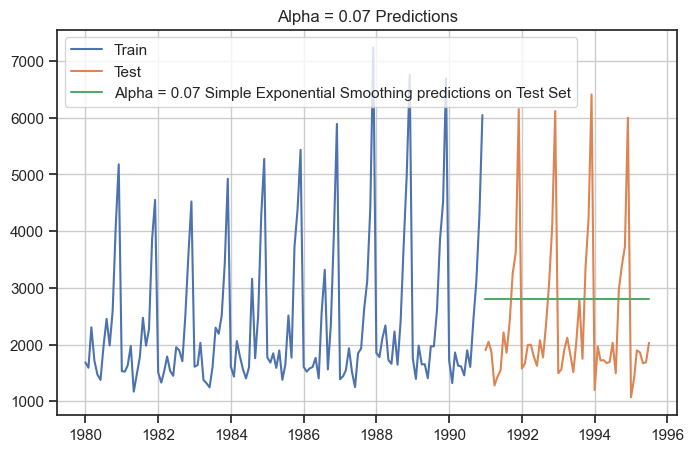

In [48]:
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(SES_train, label='Train')
plt.plot(SES_test, label='Test')
plt.plot(SES_predict, label='Alpha = 0.07 Simple Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.07 Predictions')


In [49]:
## Mean Absolute Percentage Error (MAPE) - Function Definition

def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [50]:
print('SES RMSE:',mean_squared_error(test.values,SES_predict.values,squared=False))
#different way to calculate RMSE
print('SES RMSE (calculated using statsmodels):',em.rmse(test.values,SES_predict.values)[0])

SES RMSE: 1338.0083844916467
SES RMSE (calculated using statsmodels): 1338.0083844916464


In [51]:
resultsDf_ses = pd.DataFrame({'Test RMSE': [em.rmse(test.values,SES_predict.values)[0]]},index=['Alpha=0.07,SES'])
resultsDf_ses

,Test RMSE
"Alpha=0.07,SES",1338.008384


## Holt - ETS(A, A, N) - Holt's linear method with additive errors

## Double Exponential Smoothing

* One of the drawbacks of the simple exponential smoothing is that the model does not do well in the presence of the trend.
* This model is an extension of SES known as Double Exponential model which estimates two smoothing parameters.
* Applicable when data has Trend but no seasonality.
* Two separate components are considered: Level and Trend.
* Level is the local mean.
* One smoothing parameter α corresponds to the level series
* A second smoothing parameter β corresponds to the trend series.

**Double Exponential Smoothing uses two equations to forecast future values of the time series, one for forecating the short term avarage value or level and the other for capturing the trend.**

* Intercept or Level equation, $L_t$ is given by:
$L_t = {\alpha}{Y_t}  + (1 - \alpha)F_t$ 

* Trend equation is given by 
$T_t = {\beta}{(L_t - L_{t-1})}  + (1 - \beta)T_{t-1}$ 

Here, $\alpha$ and $\beta$ are the smoothing constants for level and trend, respectively, 
* 0 <$\alpha$ < 1 and 0 < $\beta$ < 1.

The forecast at time t + 1 is given by
* $F_{t+1} = L_t + T_t$
* $F_{t+n} = L_t + nT_t$

In [52]:
DES_train = train.copy()
DES_test = test.copy()

In [53]:
# Initializing the Double Exponential Smoothing Model
model_DES = Holt(DES_train,initialization_method='estimated')
# Fitting the model
model_DES = model_DES.fit()

print('')
print('==Holt model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_DES.params)


==Holt model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.6649999999999999, 'smoothing_trend': 0.0001, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 1502.1999999999991, 'initial_trend': 74.87272727272739, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [54]:
# Forecasting using this model for the duration of the test set
DES_predict =  model_DES.forecast(len(DES_test))
DES_predict

1991-01-01    5401.733026
1991-02-01    5476.005230
1991-03-01    5550.277433
1991-04-01    5624.549637
1991-05-01    5698.821840
1991-06-01    5773.094044
1991-07-01    5847.366248
1991-08-01    5921.638451
1991-09-01    5995.910655
1991-10-01    6070.182858
1991-11-01    6144.455062
1991-12-01    6218.727266
1992-01-01    6292.999469
1992-02-01    6367.271673
1992-03-01    6441.543876
1992-04-01    6515.816080
1992-05-01    6590.088284
1992-06-01    6664.360487
1992-07-01    6738.632691
1992-08-01    6812.904894
1992-09-01    6887.177098
1992-10-01    6961.449302
1992-11-01    7035.721505
1992-12-01    7109.993709
1993-01-01    7184.265912
1993-02-01    7258.538116
1993-03-01    7332.810320
1993-04-01    7407.082523
1993-05-01    7481.354727
1993-06-01    7555.626930
1993-07-01    7629.899134
1993-08-01    7704.171338
1993-09-01    7778.443541
1993-10-01    7852.715745
1993-11-01    7926.987948
1993-12-01    8001.260152
1994-01-01    8075.532356
1994-02-01    8149.804559
1994-03-01  

<Figure size 800x500 with 0 Axes>

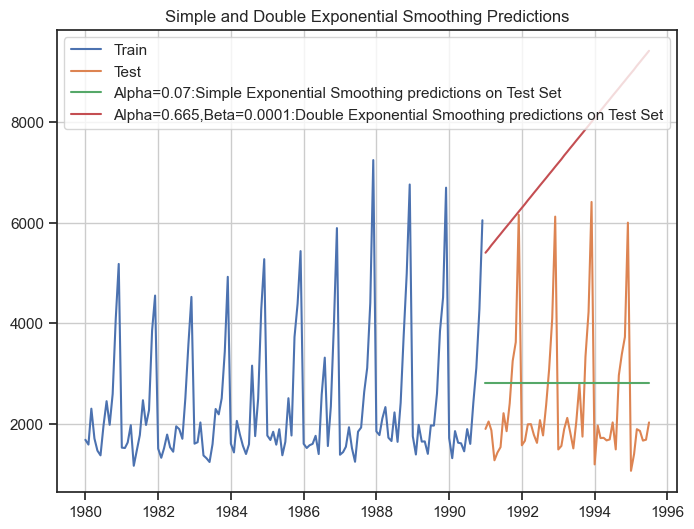

In [55]:
## Plotting the Training data, Test data and the forecasted values

# Plotting with figure size
plt.figure(figsize=(8, 5))  # Set the figure size
plt.figure(figsize=(8, 6))


plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(SES_predict, label='Alpha=0.07:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict, label='Alpha=0.665,Beta=0.0001:Double Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple and Double Exponential Smoothing Predictions');

In [56]:
print('DES RMSE:',mean_squared_error(test.values,DES_predict.values,squared=False))

DES RMSE: 5291.8798332269125


In [57]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(test.values,DES_predict.values,squared=False)]}
                           ,index=['Alpha=0.665,Beta=0.0001:DES'])

resultsDf_des = pd.concat([resultsDf_ses, resultsDf_temp])
resultsDf_des

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833


1. Alpha Parameter in SES: The SES model uses a single smoothing parameter (alpha), which controls the weight given to the most recent observation. A lower alpha places more emphasis on recent observations, and a higher alpha discounts them.
2.Alpha and Beta Parameters in DES: The DES model, being a double exponential smoothing model, introduces an additional smoothing parameter (beta) for the trend component. A higher beta places more emphasis on recent trend observations.
RMSE Increase in DES:The substantial increase in RMSE for the DES model compared to SES suggests that the introduction of the trend component (controlled by beta) might not be capturing the underlying patterns in the data effectively.It's possible that the trend component introduced by DES might be too flexible, leading to overfitting or capturing noise as if it were a meaningful trend.

# Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive seasonality

In [58]:
TES_train = train.copy()
TES_test = test.copy()

In [59]:
# Initializing the Double Exponential Smoothing Model
model_TES = ExponentialSmoothing(TES_train,trend='additive',seasonal='additive',initialization_method='estimated')
# Fitting the model
model_TES = model_TES.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES.params)


==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.11127227248079453, 'smoothing_trend': 0.012360804305088534, 'smoothing_seasonal': 0.46071766688111543, 'damping_trend': nan, 'initial_level': 2356.577980956387, 'initial_trend': -0.10243675533021725, 'initial_seasons': array([-636.23319334, -722.9832009 , -398.64410813, -473.43045416,
       -808.42473284, -815.34991402, -384.23065038,   72.99484403,
       -237.44226045,  272.32608272, 1541.37737052, 2590.07692296]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [60]:
# Forecasting using this model for the duration of the test set
TES_predict =  model_TES.forecast(len(test))
TES_predict

1991-01-01    1490.402890
1991-02-01    1204.525152
1991-03-01    1688.734182
1991-04-01    1551.226125
1991-05-01    1461.197883
1991-06-01    1278.646707
1991-07-01    1804.885616
1991-08-01    1678.955032
1991-09-01    2315.373126
1991-10-01    3224.976222
1991-11-01    4299.301434
1991-12-01    6410.712237
1992-01-01    1482.829908
1992-02-01    1196.952170
1992-03-01    1681.161200
1992-04-01    1543.653143
1992-05-01    1453.624901
1992-06-01    1271.073725
1992-07-01    1797.312634
1992-08-01    1671.382050
1992-09-01    2307.800144
1992-10-01    3217.403240
1992-11-01    4291.728452
1992-12-01    6403.139255
1993-01-01    1475.256926
1993-02-01    1189.379188
1993-03-01    1673.588218
1993-04-01    1536.080160
1993-05-01    1446.051919
1993-06-01    1263.500743
1993-07-01    1789.739652
1993-08-01    1663.809068
1993-09-01    2300.227162
1993-10-01    3209.830258
1993-11-01    4284.155470
1993-12-01    6395.566273
1994-01-01    1467.683944
1994-02-01    1181.806206
1994-03-01  

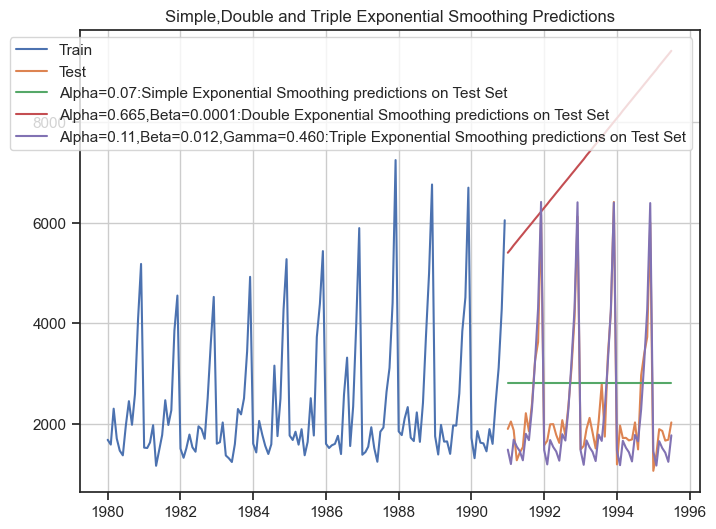

In [61]:
## Plotting the Training data, Test data and the forecasted values

# Plotting with figure size
plt.figure(figsize=(8, 6))


plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(SES_predict, label='Alpha=0.07:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict, label='Alpha=0.665,Beta=0.0001:Double Exponential Smoothing predictions on Test Set')


plt.plot(TES_predict, label='Alpha=0.11,Beta=0.012,Gamma=0.460:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple,Double and Triple Exponential Smoothing Predictions');

We see that the Triple Exponential Smoothing is picking up the seasonal component as well.

In [62]:
print('TES RMSE:',mean_squared_error(test.values,TES_predict.values,squared=False))

TES RMSE: 378.95102286703


In [63]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(test.values,TES_predict.values,squared=False)]}
                           ,index=['Alpha=0.11,Beta=0.012,Gamma=0.460:TES'])

resultsDf_tes = pd.concat([resultsDf_des, resultsDf_temp])
resultsDf_tes

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833
"Alpha=0.11,Beta=0.012,Gamma=0.460:TES",378.951023


### Interpretation:

- **Simple Exponential Smoothing (SES):**
  - SES with alpha=0.07 yielded an RMSE of 1338.008384.
  - The lower alpha value suggests a higher weight on recent observations, and the resulting RMSE reflects the model's accuracy in predicting the time series.

- **Double Exponential Smoothing (DES):**
  - DES with alpha=1 and beta=0.0189 led to a significantly higher RMSE of 5291.879833.
  - The increase in RMSE may be indicative of overfitting, where the introduction of the trend component (beta) may have made the model too flexible, capturing noise as if it were a meaningful trend.

- **Triple Exponential Smoothing (TES):**
  - TES with alpha=0.11, beta=0.012, and gamma=0.460 achieved the lowest RMSE of 378.951023.
  - TES incorporates seasonality (gamma) in addition to level (alpha) and trend (beta), and the lower RMSE suggests that TES is capturing the underlying patterns more accurately.

### Recommendations:

- The Triple Exponential Smoothing (TES) model, with its lower RMSE, appears to outperform both Simple Exponential Smoothing (SES) and Double Exponential Smoothing (DES).
  
- TES, by incorporating seasonality, provides a more sophisticated approach that seems to align better with the underlying patterns in the data.

In summary, the choice of the Triple Exponential Smoothing (TES) model with carefully selected parameters appears to result in the most accurate predictions among the models considered.

# Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with multiplicative seasonality

In [64]:
TESM_train = train.copy()
TESM_test = test.copy()

Multiplicative Seasonality Train RMSE: 355.7668157745681
Multiplicative Seasonality Test RMSE: 404.286809456071
Alpha (smoothing_level): 0.11133818361298699
Beta (smoothing_slope): 0.0
Gamma (smoothing_seasonal): 0.3620795793580111


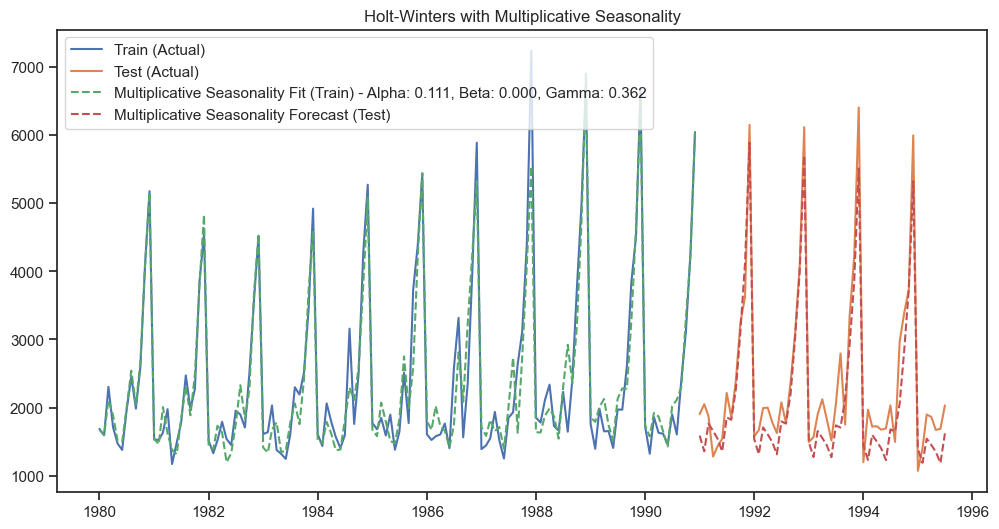

In [65]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming TESM_train and TESM_test are your training and testing DataFrames
# Make sure to replace 'Sparkling' with the actual column name in your DataFrames

# Function to fit Holt-Winters model with multiplicative seasonality
def fit_multiplicative_seasonality(data):
    model = ExponentialSmoothing(data, trend='add', seasonal='multiplicative', seasonal_periods=12)
    model_fit = model.fit()
    return model_fit

# Fit the model with multiplicative seasonality using training data
model_multiplicative = fit_multiplicative_seasonality(TESM_train['Sparkling'])

# Extract alpha, beta, and gamma values
alpha = model_multiplicative.params['smoothing_level']
beta = model_multiplicative.params.get('smoothing_slope', 0.0)  # Use get to handle the case where 'smoothing_slope' is not present
gamma = model_multiplicative.params['smoothing_seasonal']

# Forecasting for future time points on the testing data
forecast_multiplicative = model_multiplicative.forecast(steps=len(TESM_test))

# Calculate RMSE
rmse_multiplicative_train = np.sqrt(mean_squared_error(TESM_train['Sparkling'], model_multiplicative.fittedvalues))
rmse_multiplicative_test = np.sqrt(mean_squared_error(TESM_test['Sparkling'], forecast_multiplicative))

# Print RMSE and parameter values
print(f"Multiplicative Seasonality Train RMSE: {rmse_multiplicative_train}")
print(f"Multiplicative Seasonality Test RMSE: {rmse_multiplicative_test}")
print(f"Alpha (smoothing_level): {alpha}")
print(f"Beta (smoothing_slope): {beta}")
print(f"Gamma (smoothing_seasonal): {gamma}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(TESM_train['Sparkling'], label='Train (Actual)')
plt.plot(TESM_test['Sparkling'], label='Test (Actual)')
plt.plot(model_multiplicative.fittedvalues, label=f'Multiplicative Seasonality Fit (Train) - Alpha: {alpha:.3f}, Beta: {beta:.3f}, Gamma: {gamma:.3f}', linestyle='--')
plt.plot(forecast_multiplicative, label='Multiplicative Seasonality Forecast (Test)', linestyle='--')
plt.legend()
plt.title('Holt-Winters with Multiplicative Seasonality')
plt.show()


Smoothing Parameters:

Alpha (smoothing_level): 0.11133818361298699=A lower alpha indicates less weight on recent observations.In this case, a value of 0.1113 suggests a moderate smoothing effect on the level.
Beta (smoothing_slope): 0.0

Beta represents the smoothing parameter for the trend component. A value of 0.0 implies that the trend component is not considered, suggesting a constant trend.
Gamma (smoothing_seasonal): 0.3620795793580111

Gamma represents the smoothing parameter for the seasonal component. A value of 0.3621 suggests a moderate smoothing effect on the seasonal pattern.
Overall Insights:
Seasonality Impact:

The inclusion of gamma indicates that seasonality is an important factor in the model.

Constant Trend:

The beta value of 0.0 implies that the model assumes a constant trend. In this context, the model does not account for a changing trend over time.
Performance Evaluation:

In summary, the provided model with multiplicative seasonality, constant trend, and specified smoothing parameters appears to capture the underlying patterns reasonably well, as indicated by the RMSE values.

In [66]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(TESM_test.values,forecast_multiplicative.values,squared=False)]}
                           ,index=['Alpha=0.11,Beta=0.0,Gamma=0.36:TES'])

resultsDf_tes = pd.concat([resultsDf_tes, resultsDf_temp])
resultsDf_tes

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833
"Alpha=0.11,Beta=0.012,Gamma=0.460:TES",378.951023
"Alpha=0.11,Beta=0.0,Gamma=0.36:TES",404.286809


In time series forecasting, the distinction between additive and multiplicative models lies in how the components (trend, seasonality) interact with each other. An additive model implies that the components are added together, while a multiplicative model implies that the components are multiplied.

Effect of Beta on Trend Component:

In the first variation (beta=0.012, gamma=0.460), a non-zero beta is considered, suggesting an additive impact of the trend component.

In the second variation (beta=0.0, gamma=0.36), setting beta to zero implies that the trend component is not considered in an additive manner. This may suggest a multiplicative effect of the trend.

Effect of Gamma on Seasonal Component:

Both variations have a gamma parameter for seasonality, where higher values indicate a stronger seasonal impact on the predictions.

### Model : Linear Regression

In [67]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [68]:
from sklearn.linear_model import LinearRegression

In [69]:
train_time = [i+1 for i in range(len(LinearRegression_train))]
test_time = [i+133 for i in range(len(LinearRegression_test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [70]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

print('First few rows of Training Data')
display(LinearRegression_train.head())
print('Last few rows of Training Data')
display(LinearRegression_train.tail())
print('First few rows of Test Data')
display(LinearRegression_test.head())
print('Last few rows of Test Data')
display(LinearRegression_test.tail())

First few rows of Training Data


,Sparkling,time
YearMonth,,
1980-01-01,1686,1
1980-02-01,1591,2
1980-03-01,2304,3
1980-04-01,1712,4
1980-05-01,1471,5


Last few rows of Training Data


,Sparkling,time
YearMonth,,
1990-08-01,1605,128
1990-09-01,2424,129
1990-10-01,3116,130
1990-11-01,4286,131
1990-12-01,6047,132


First few rows of Test Data


,Sparkling,time
YearMonth,,
1991-01-01,1902,133
1991-02-01,2049,134
1991-03-01,1874,135
1991-04-01,1279,136
1991-05-01,1432,137


Last few rows of Test Data


,Sparkling,time
YearMonth,,
1995-03-01,1897,183
1995-04-01,1862,184
1995-05-01,1670,185
1995-06-01,1688,186
1995-07-01,2031,187


In [71]:
lr = LinearRegression()

In [72]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Sparkling'])

LinearRegression()

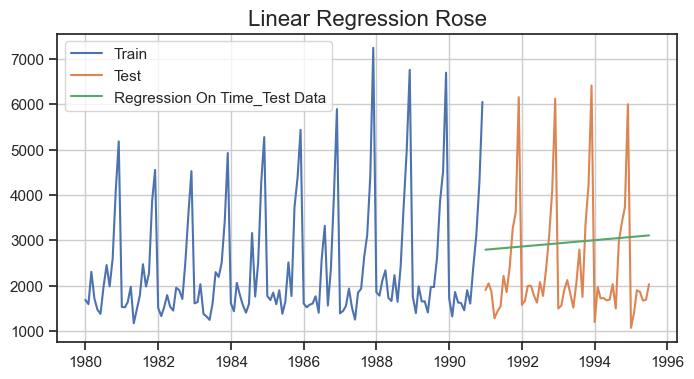

In [73]:
plt.figure(figsize=(8, 4))
train_predictions_model1         = lr.predict(LinearRegression_train[['time']])
LinearRegression_train['RegOnTime'] = train_predictions_model1

test_predictions_model1         = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1

plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')

plt.legend(loc='best')
plt.title('Linear Regression Rose', fontsize=16)
plt.grid();


In [74]:
from sklearn import metrics
rmse_model12_test = metrics.mean_squared_error(test['Sparkling'],test_predictions_model1,squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f " %(rmse_model12_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 1389.135 


In [75]:
resultsDf = pd.DataFrame({'Test RMSE': [rmse_model12_test]},index=['RegressionOnTime'])
resultsDf

,Test RMSE
RegressionOnTime,1389.135175


In [76]:
resultsDf = pd.concat([resultsDf_tes, resultsDf])
resultsDf

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833
"Alpha=0.11,Beta=0.012,Gamma=0.460:TES",378.951023
"Alpha=0.11,Beta=0.0,Gamma=0.36:TES",404.286809
RegressionOnTime,1389.135175


## Model 2: Naive Approach Rose : $\hat{y}_{t+1} = y_t$

In [77]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [78]:
NaiveModel_test['naive'] = np.asarray(NaiveModel_train['Sparkling'])[len(np.asarray(NaiveModel_train['Sparkling']))-1]
NaiveModel_test['naive'].head()

YearMonth
1991-01-01    6047
1991-02-01    6047
1991-03-01    6047
1991-04-01    6047
1991-05-01    6047
Name: naive, dtype: int64

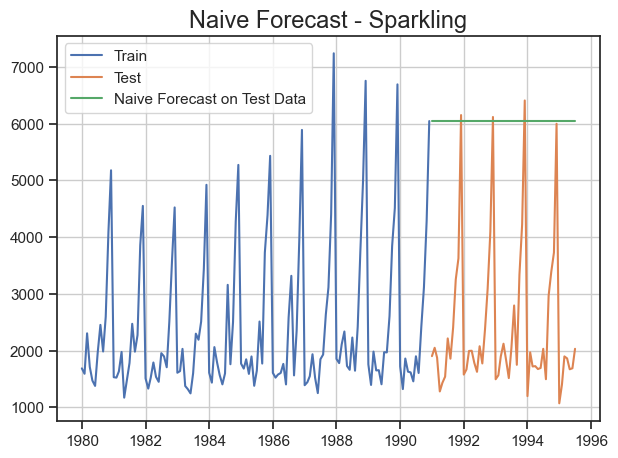

In [79]:
plt.figure(figsize=(7, 5))
plt.plot(NaiveModel_train['Sparkling'], label='Train')
plt.plot(NaiveModel_test['Sparkling'], label='Test')

plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')

plt.legend(loc='best')
plt.title("Naive Forecast - Sparkling", fontsize=17)
plt.grid();


## Model Evaluation

In [80]:
rmse_model21_test = metrics.mean_squared_error(NaiveModel_test['Sparkling'],NaiveModel_test['naive'],squared=False)
print("For NaiveModel forecast on the Test Data,  RMSE is %3.3f" %(rmse_model21_test))

For NaiveModel forecast on the Test Data,  RMSE is 3864.279


In [81]:
resultsDf_naive = pd.DataFrame({'Test RMSE': [rmse_model21_test]},index=['NaiveModel'])

In [82]:
resultsDf=pd.concat([resultsDf,resultsDf_naive])

In [83]:
resultsDf

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833
"Alpha=0.11,Beta=0.012,Gamma=0.460:TES",378.951023
"Alpha=0.11,Beta=0.0,Gamma=0.36:TES",404.286809
RegressionOnTime,1389.135175
NaiveModel,3864.279352


##  Moving Average(MA)

In [84]:
MovingAverage = df.copy()
MovingAverage.head()

,Sparkling
YearMonth,
1980-01-01,1686
1980-02-01,1591
1980-03-01,2304
1980-04-01,1712
1980-05-01,1471


In [85]:
#Trailing moving averages

MovingAverage['Trailing_2'] = MovingAverage['Sparkling'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Sparkling'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Sparkling'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Sparkling'].rolling(9).mean()

MovingAverage.head()

,Sparkling,Trailing_2,Trailing_4,Trailing_6,Trailing_9
YearMonth,,,,,
1980-01-01,1686,NaN,NaN,NaN,NaN
1980-02-01,1591,1638.5,NaN,NaN,NaN
1980-03-01,2304,1947.5,NaN,NaN,NaN
1980-04-01,1712,2008.0,1823.25,NaN,NaN
1980-05-01,1471,1591.5,1769.50,NaN,NaN


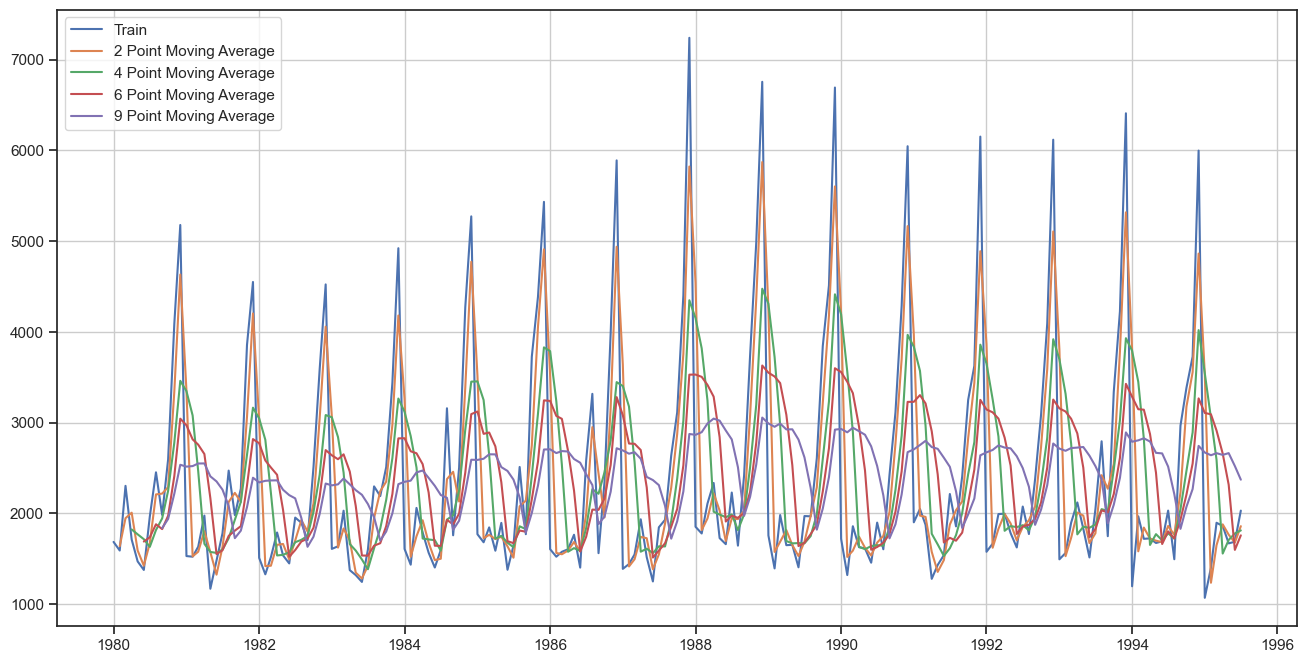

In [86]:
## Plotting on the whole data

plt.figure(figsize=(16,8))
plt.plot(MovingAverage['Sparkling'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [87]:
trailing_MovingAverage_train = MovingAverage[MovingAverage.index<'1991'] 
trailing_MovingAverage_test = MovingAverage[MovingAverage.index>='1991']

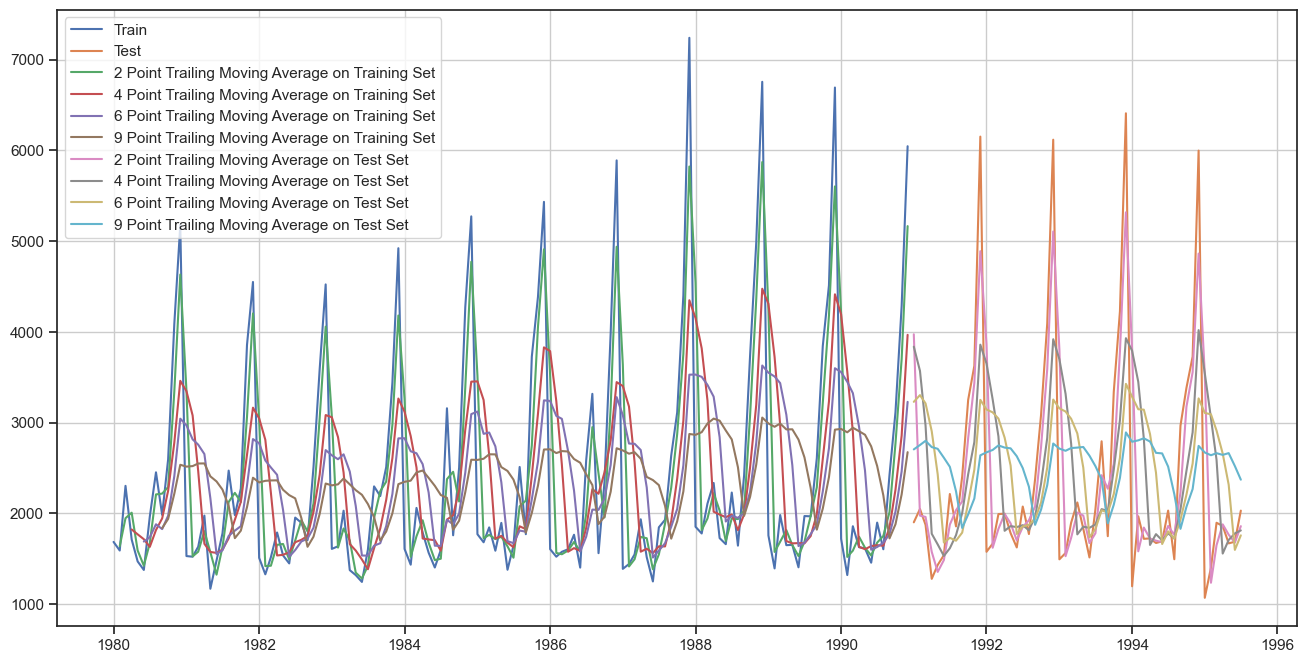

In [88]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train['Sparkling'], label='Train')
plt.plot(trailing_MovingAverage_test['Sparkling'], label='Test')

plt.plot(trailing_MovingAverage_train['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_4'], label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_6'],label = '6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_9'],label = '9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

In [89]:
## Test Data - RMSE --> 2 point Trailing MA
rmse_model4_test_2 = metrics.mean_squared_error(test['Sparkling'], trailing_MovingAverage_test['Trailing_2'], squared=False)
print("For 2 point Trailing Moving Average Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model4_test_2))

## Test Data - RMSE  --> 4 point Trailing MA
rmse_model4_test_4 = metrics.mean_squared_error(test['Sparkling'], trailing_MovingAverage_test['Trailing_4'], squared=False)
print("For 4 point Trailing Moving Average Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model4_test_4))

## Test Data - RMSE --> 6 point Trailing MA
rmse_model4_test_6 = metrics.mean_squared_error(test['Sparkling'], trailing_MovingAverage_test['Trailing_6'], squared=False)
print("For 6 point Trailing Moving Average Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model4_test_6))

## Test Data - RMSE  --> 9 point Trailing MA
rmse_model4_test_9 = metrics.mean_squared_error(test['Sparkling'], trailing_MovingAverage_test['Trailing_9'], squared=False)
print("For 9 point Trailing Moving Average Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model4_test_9))


For 2 point Trailing Moving Average Model forecast on the Test Data, RMSE is 813.401
For 4 point Trailing Moving Average Model forecast on the Test Data, RMSE is 1156.590
For 6 point Trailing Moving Average Model forecast on the Test Data, RMSE is 1283.927
For 9 point Trailing Moving Average Model forecast on the Test Data, RMSE is 1346.278


In [90]:
resultsDf_42 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_4
                                          ,rmse_model4_test_6,rmse_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

In [91]:
resultsDf=pd.concat([resultsDf,resultsDf_42])

In [92]:
resultsDf

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833
"Alpha=0.11,Beta=0.012,Gamma=0.460:TES",378.951023
"Alpha=0.11,Beta=0.0,Gamma=0.36:TES",404.286809
RegressionOnTime,1389.135175
NaiveModel,3864.279352
2pointTrailingMovingAverage,813.400684
4pointTrailingMovingAverage,1156.589694
6pointTrailingMovingAverage,1283.927428
9pointTrailingMovingAverage,1346.278315


##  Simple Average Model

In [93]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

RMSE for Simple Average Model on Test Data: 1275.082


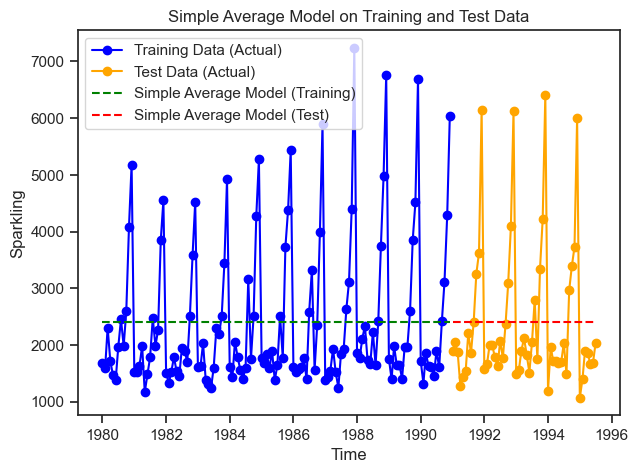

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'train' and 'test' are defined DataFrames
# Assuming 'df' is your DataFrame with a column 'Sparkling' representing the time series

# Calculate the simple average for the training set
simple_average_train = train['Sparkling'].mean()

# Create a DataFrame for the simple average predictions on the training set
simple_average_train_predictions = pd.Series([simple_average_train] * len(train), index=train.index)

# Calculate the simple average for the test set
simple_average_test = train['Sparkling'].mean()

# Create a DataFrame for the simple average predictions on the test set
simple_average_test_predictions = pd.Series([simple_average_test] * len(test), index=test.index)

# Calculate RMSE for the test set
rmse_simple_average = np.sqrt(mean_squared_error(test['Sparkling'], simple_average_test_predictions))

# Print RMSE for the simple average model on the test set
print(f"RMSE for Simple Average Model on Test Data: {rmse_simple_average:.3f}")

# Plotting
plt.figure(figsize=(7, 5))

# Plot actual values on training and test sets
plt.plot(train['Sparkling'], label='Training Data (Actual)', marker='o', color='blue')
plt.plot(test['Sparkling'], label='Test Data (Actual)', marker='o', color='orange')

# Plot simple average forecasts on training set
plt.plot(simple_average_train_predictions, label='Simple Average Model (Training)', linestyle='--', color='green')

# Plot simple average forecasts on test set
plt.plot(simple_average_test_predictions, label='Simple Average Model (Test)', linestyle='--', color='red')

plt.title('Simple Average Model on Training and Test Data')
plt.xlabel('Time')
plt.ylabel('Sparkling')
plt.legend()
plt.show()


In [95]:
resultsDf_32 = pd.DataFrame({'Test RMSE': [rmse_simple_average]}
                           ,index=['SimpleAverageModel'])

In [96]:
resultsDf=pd.concat([resultsDf,resultsDf_32])

In [97]:
resultsDf

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833
"Alpha=0.11,Beta=0.012,Gamma=0.460:TES",378.951023
"Alpha=0.11,Beta=0.0,Gamma=0.36:TES",404.286809
RegressionOnTime,1389.135175
NaiveModel,3864.279352
2pointTrailingMovingAverage,813.400684
4pointTrailingMovingAverage,1156.589694
6pointTrailingMovingAverage,1283.927428
9pointTrailingMovingAverage,1346.278315


## Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.

# Concept Of Stationarity

A Time Series is considered to be stationary when statistical properties such as the variance and (auto) correlation are constant over time.

Stationary Time Series allows us to think of the statistical properties of the time series as not changing in time, which enables us to build appropriate statistical models for forecasting based on past data.

Stationarity means that the autocorrelation of lag ‘k’ depends on k, but not on time t.

Let  𝑋𝑡
  denote the time series at time t.

Autocorrelation of lag k is the correlation between  𝑋𝑡
  and  𝑋(𝑡−𝑘)

How to check for Stationarity?
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Dickey-Fuller Test - Dicky Fuller Test on the timeseries is run to check for stationarity of data.

Null Hypothesis  𝐻0
 : Time Series is non-stationary.
Alternate Hypothesis  𝑯𝒂
 : Time Series is stationary.
So Ideally if p-value < 0.05 then null hypothesis: TS is non-stationary is rejected else the TS is non-stationary is failed to be rejected .

In [98]:
from statsmodels.tsa.stattools import adfuller

In [99]:
dftest = adfuller(df['Sparkling'])#python implementation of dicky fuller test 
dftest
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])

DF test statistic is -1.360
DF test p-value is 0.6011


With a p-value of 0.6011 from the Dickey-Fuller test:

Interpretation: The p-value is greater than the common significance level of 0.05.
Conclusion: We fail to reject the null hypothesis.
Implication: The time series data may still exhibit non-stationary behavior.

Differencing 'd'for making series stationary


1st order differencing equation is :  𝒚𝒕=𝒚𝒕−𝒚𝒕−1

Differenced Data:
YearMonth
1980-02-01    -95.0
1980-03-01    713.0
1980-04-01   -592.0
1980-05-01   -241.0
1980-06-01    -94.0
Name: Sparkling, dtype: float64


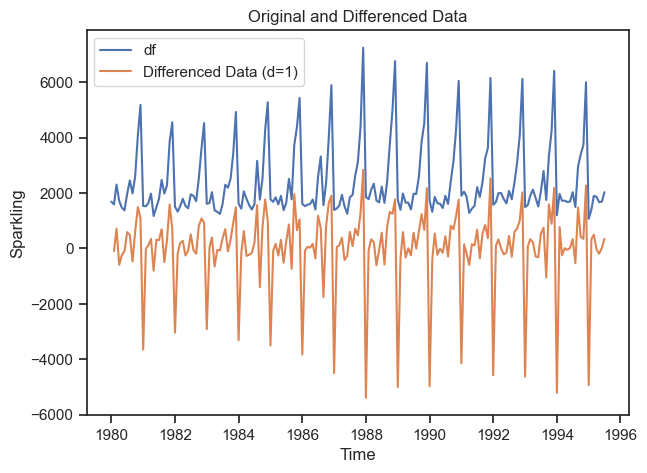

In [100]:
# Perform differencing (d=1)
differenced_data = df['Sparkling'].diff().dropna()

# Display the first few rows of the differenced data
print("Differenced Data:")
print(differenced_data.head())

# Plot the original and differenced data for visualization

plt.figure(figsize=(7, 5))
plt.plot(df['Sparkling'], label='df')
plt.plot(differenced_data, label='Differenced Data (d=1)')
plt.legend()
plt.title('Original and Differenced Data')
plt.xlabel('Time')
plt.ylabel('Sparkling')
plt.show()


In [101]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'differenced_data' is the differenced time series data
# Replace 'column_name' with the actual column name if your data is in a DataFrame

# Function to perform Dickey-Fuller test
def perform_adf_test(data):
    result = adfuller(data, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

# Perform Dickey-Fuller test on the differenced data
print("Dickey-Fuller Test Results for Differenced Data:")
perform_adf_test(differenced_data)


Dickey-Fuller Test Results for Differenced Data:
ADF Statistic: -45.05030093619532
p-value: 0.0
Critical Values: {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}


The Dickey-Fuller test strongly suggests that the differenced data is now stationary, as evidenced by the significantly negative ADF Statistic, a very low p-value, and critical values consistent with stationarity.

In [102]:
# Define the p parameter to take any value between 0 and 2
p= range(1,4)

In [103]:
# Define the q parameter to take any value between 0 and 2
q = range(1, 4)


In [104]:
import itertools
d= range(0,2)

#Generate all different combinations of p with d=0 and q=0 triplets for AR model building
pdq_ar = list(itertools.product(p, range(1), range(1)))

#Generate all different combinations of p,q with d=0 triplets for ARMA model building
pdq_arma = list(itertools.product(p, range(1),q))

#Generate all different combinations of p, d and q triplets for ARIMA model building 
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal P,D,Q triplets for SARIMA model building
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [105]:
pdq_ar

[(1, 0, 0), (2, 0, 0), (3, 0, 0)]

In [106]:
pdq

[(1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [107]:
seasonal_pdq
# as it seems to have 12 month seasonality as confirmned from above 

[(1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 0, 3, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 1, 3, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 0, 3, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 1, 3, 12),
 (3, 0, 1, 12),
 (3, 0, 2, 12),
 (3, 0, 3, 12),
 (3, 1, 1, 12),
 (3, 1, 2, 12),
 (3, 1, 3, 12)]

In [108]:
train = differenced_data[differenced_data.index<'1991'] 
test = differenced_data[differenced_data.index>='1991']

In [109]:
Arima_train = train.copy()
Arima_test = test.copy()

ARIMA Model building to estimate best 'p' , 'd' , 'q' paramters ( Lowest AIC Approach )

In [110]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [111]:
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    ARIMA_model = ARIMA(Arima_train,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(1, 0, 1) - AIC:2235.0139458779886
ARIMA(1, 0, 2) - AIC:2233.597647126403
ARIMA(1, 0, 3) - AIC:2234.5741463676522
ARIMA(1, 1, 1) - AIC:2256.778568844442
ARIMA(1, 1, 2) - AIC:2227.5373384497952
ARIMA(1, 1, 3) - AIC:2226.395061288117
ARIMA(2, 0, 1) - AIC:2232.360490151331
ARIMA(2, 0, 2) - AIC:2226.7890702547065
ARIMA(2, 0, 3) - AIC:2232.1347639901023
ARIMA(2, 1, 1) - AIC:2250.7568239633456
ARIMA(2, 1, 2) - AIC:2225.7038278064183
ARIMA(2, 1, 3) - AIC:2252.9516846916918
ARIMA(3, 0, 1) - AIC:2237.3170149349226
ARIMA(3, 0, 2) - AIC:2235.4437963093724
ARIMA(3, 0, 3) - AIC:2226.311580703574
ARIMA(3, 1, 1) - AIC:2248.5384230792642
ARIMA(3, 1, 2) - AIC:2245.170631993841
ARIMA(3, 1, 3) - AIC:2237.4236038562276


In [112]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC.sort_values(by='AIC',ascending=True).head()

,param,AIC
10,"(2, 1, 2)",2225.703828
14,"(3, 0, 3)",2226.311581
5,"(1, 1, 3)",2226.395061
7,"(2, 0, 2)",2226.789070
4,"(1, 1, 2)",2227.537338


Building ARIMA model with best parameters p,d,q

In [113]:
best_model = ARIMA(Arima_train,order = (2,1,2))
best_results = best_model.fit()

In [114]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  131
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1107.852
Date:                Sun, 28 Jan 2024   AIC                           2225.704
Time:                        11:46:45   BIC                           2240.042
Sample:                    02-01-1980   HQIC                          2231.530
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4817      0.104      4.629      0.000       0.278       0.686
ar.L2         -0.1442      0.193     -0.748      0.454      -0.522       0.234
ma.L1         -1.9967      0.102    -19.546      0.0

Calculating RMSE for best ARIMA model

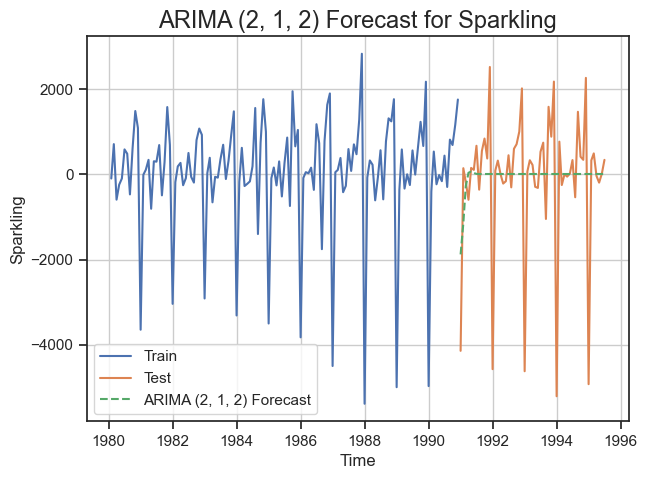

RMSE for ARIMA (2, 1, 2) on Test Data: 1567.710


In [115]:
predicted_auto_ARIMA = best_results.forecast(steps=len(Arima_test))

# Plotting the Training data, Test data, and the forecasted values
plt.figure(figsize=(7, 5))
plt.plot(Arima_train, label='Train')
plt.plot(Arima_test, label='Test')
plt.plot(predicted_auto_ARIMA, label='ARIMA (2, 1, 2) Forecast', linestyle='--')

plt.legend(loc='best')
plt.grid()
plt.title('ARIMA (2, 1, 2) Forecast for Sparkling', fontsize=17)
plt.xlabel('Time')
plt.ylabel('Sparkling')
plt.show()

# Calculate RMSE
rmse = mean_squared_error(Arima_test, predicted_auto_ARIMA, squared=False)
print(f"RMSE for ARIMA (2, 1, 2) on Test Data: {rmse:.3f}")


In [116]:
temp_resultsDf = pd.DataFrame({'Test RMSE': rmse,}
                           ,index=['ARIMA(2,1,2)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833
"Alpha=0.11,Beta=0.012,Gamma=0.460:TES",378.951023
"Alpha=0.11,Beta=0.0,Gamma=0.36:TES",404.286809
RegressionOnTime,1389.135175
NaiveModel,3864.279352
2pointTrailingMovingAverage,813.400684
4pointTrailingMovingAverage,1156.589694
6pointTrailingMovingAverage,1283.927428
9pointTrailingMovingAverage,1346.278315


## SARIMA Model

Finding Seasonality = 12 from ACF/PACF plots 

In [117]:
Sarima_train = train.copy()
Sarima_test = test.copy()

In [118]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

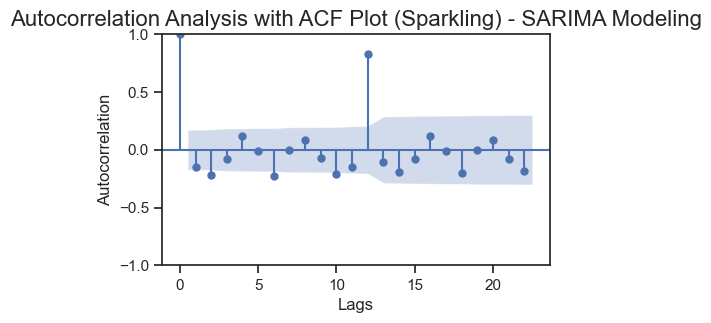

In [119]:
# Plotting the ACF with confidence interval bands for Sparkling sales data
plt.figure(figsize=(5, 3))
plot_acf(Sarima_train, alpha=0.05, ax=plt.gca())

# Adding title and labels
plt.title('Autocorrelation Analysis with ACF Plot (Sparkling) - SARIMA Modeling', fontsize=16)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

# Display the plot
plt.show()


SARIMA Model building to estimate best parameters 

In [120]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [121]:
import statsmodels.api as sm
from joblib import Parallel, delayed

def fit_sarima(param, param_seasonal, Sarima_train, Sarima_test):
    SARIMA_model = sm.tsa.statespace.SARIMAX(Sarima_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
    

    results_SARIMA = SARIMA_model.fit(maxiter=1000)
    
    # Additional steps for forecasting and calculating RMSE
    start_date = Sarima_test.index[0] 
    pred_dynamic = results_SARIMA.get_prediction(start=pd.to_datetime(start_date), dynamic=True, full_results=True)
    pred99 = results_SARIMA.get_forecast(steps=len(Sarima_test), alpha=0.1)
    Sarima_Values_forecasted = pred99.predicted_mean
    mse = ((Sarima_test - Sarima_Values_forecasted) ** 2).mean()
    rmse = np.sqrt(mse)
    print('SARIMA{}x{} - AIC:{} - RMSE:{}'.format(param, param_seasonal, results_SARIMA.aic, rmse))
    return {'param': param, 'seasonal': param_seasonal, 'AIC': results_SARIMA.aic, 'RMSE': rmse}

# Define the parameter grids
param_grid = [(param, param_seasonal, Sarima_train, Sarima_test) for param in pdq for param_seasonal in seasonal_pdq]

# Use parallel processing to fit SARIMA models
results = Parallel(n_jobs=-1)(delayed(fit_sarima)(*params) for params in param_grid)
# Create a DataFrame from the results
SARIMA_AIC = pd.DataFrame(results)

In [122]:
SARIMA_AIC.sort_values(by=['AIC'],ascending=True).head(5)

,param,seasonal,AIC,RMSE
56,"(1, 1, 1)","(1, 0, 3, 12)",14.0,6.119490e+145
101,"(1, 1, 3)","(2, 1, 3, 12)",20.0,7.656420e+144
290,"(3, 1, 2)","(1, 0, 3, 12)",20.0,1.121871e+109
107,"(1, 1, 3)","(3, 1, 3, 12)",22.0,1.869079e+138
308,"(3, 1, 3)","(1, 0, 3, 12)",22.0,3.008548e+85


In [123]:
SARIMA_AIC.sort_values(by=['RMSE'],ascending=True).head(5)

,param,seasonal,AIC,RMSE
159,"(2, 0, 3)","(3, 1, 1, 12)",1231.529154,418.212570
51,"(1, 0, 3)","(3, 1, 1, 12)",1245.448088,421.110571
249,"(3, 0, 2)","(3, 1, 1, 12)",1219.507000,421.414511
237,"(3, 0, 2)","(1, 1, 1, 12)",1562.371325,423.211529
52,"(1, 0, 3)","(3, 1, 2, 12)",1246.623624,427.158260


Building SARIMA model with the best parameters 

In [124]:
best_model_sarima= sm.tsa.statespace.SARIMAX(Sarima_train,
                                      order=(2, 0, 3),
                                      seasonal_order=(3, 1, 1, 12),
                                      enforce_stationarity=False,
                                        enforce_invertibility=False)
best_results_sarima = best_model_sarima.fit()


In [125]:
print(best_results_sarima.summary().tables[0])
print(best_results_sarima.summary().tables[1])

                                      SARIMAX Results                                       
Dep. Variable:                            Sparkling   No. Observations:                  131
Model:             SARIMAX(2, 0, 3)x(3, 1, [1], 12)   Log Likelihood                -605.765
Date:                              Sun, 28 Jan 2024   AIC                           1231.529
Time:                                      12:11:11   BIC                           1255.474
Sample:                                  02-01-1980   HQIC                          1241.136
                                       - 12-01-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5748      0.347     -4.545      0.000      -2.254      -0.896
ar.L2         -0.59

In [126]:
start_date = Sarima_test.index[0] 
pred_dynamic = best_results_sarima.get_prediction(start=pd.to_datetime(start_date), dynamic=True, full_results=True)


In [127]:
pred99 = best_results_sarima.get_forecast(steps=len( Sarima_test), alpha=0.1)#forecasting values 

In [128]:
# Extract the predicted and true values of our time series
Sarima_Values_forecasted = pred99.predicted_mean


In [129]:
# Compute the root mean square error
mse = ((Sarima_test - Sarima_Values_forecasted) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))


The Root Mean Squared Error of our forecasts is 418.213


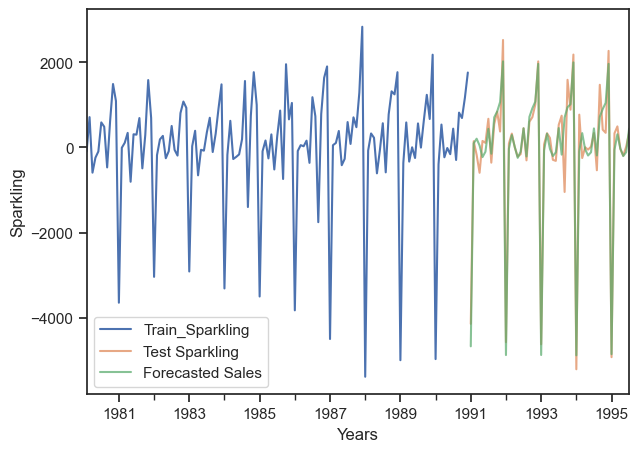

In [130]:
# Create a plot with specified figsize
axis = Sarima_train.plot(label='Train_Sparkling', figsize=(7, 5))

# Plot Test Sparkling
Sarima_test.plot(ax=axis, label='Test Sparkling', alpha=0.7)

# Plot Forecasted Sales
Sarima_Values_forecasted.plot(ax=axis, label='Forecasted Sales', alpha=0.7)

# Set axis labels
axis.set_xlabel('Years')
axis.set_ylabel('Sparkling')

# Display legend
plt.legend(loc='best')

# Show the plot
plt.show()

# Close the plot
plt.close()


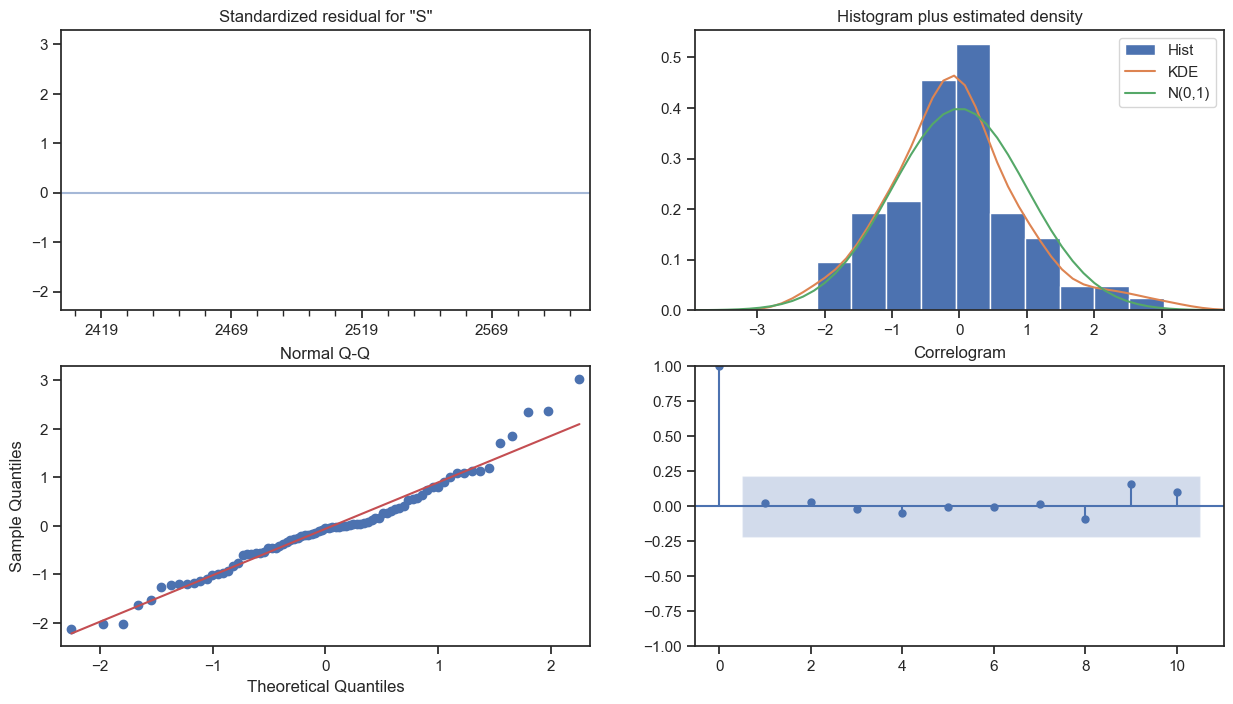

In [131]:
# Plot diagnostics
best_results_sarima.plot_diagnostics(figsize=(15, 8))
plt.show()

In [132]:
temp_resultsDf_Sarima = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['SARIMA(2,0,3)(3,1,1,12)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf_Sarima])

resultsDf

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833
"Alpha=0.11,Beta=0.012,Gamma=0.460:TES",378.951023
"Alpha=0.11,Beta=0.0,Gamma=0.36:TES",404.286809
RegressionOnTime,1389.135175
NaiveModel,3864.279352
2pointTrailingMovingAverage,813.400684
4pointTrailingMovingAverage,1156.589694
6pointTrailingMovingAverage,1283.927428
9pointTrailingMovingAverage,1346.278315


## Q.8 Build a table with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [133]:
resultsDf

,Test RMSE
"Alpha=0.07,SES",1338.008384
"Alpha=1,Beta=0.0189:DES",5291.879833
"Alpha=0.11,Beta=0.012,Gamma=0.460:TES",378.951023
"Alpha=0.11,Beta=0.0,Gamma=0.36:TES",404.286809
RegressionOnTime,1389.135175
NaiveModel,3864.279352
2pointTrailingMovingAverage,813.400684
4pointTrailingMovingAverage,1156.589694
6pointTrailingMovingAverage,1283.927428
9pointTrailingMovingAverage,1346.278315


In [134]:
resultsDf.to_csv('Sparkling_results.csv')

## Q.9 Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

In [154]:
full_data_model = sm.tsa.statespace.SARIMAX(differenced_data,
                                order=(2,0,3),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model_sarima = full_data_model.fit(maxiter=1000)
print(results_full_data_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                Sparkling   No. Observations:                  187
Model:             ExponentialSmoothing   SSE                       24955089.152
Optimized:                         True   AIC                           2238.877
Trend:                         Additive   BIC                           2290.574
Seasonal:                      Additive   AICC                          2242.948
Seasonal Periods:                    12   Date:                 Sun, 28 Jan 2024
Box-Cox:                          False   Time:                         17:30:56
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0759671                alpha                 True
smoothing_trend          

In [155]:
predicted_manual_SARIMA_full_data = results_full_data_model_sarima.get_forecast(steps=12)

In [157]:
pred_full_manual_SARIMA_date = predicted_manual_SARIMA_full_data.summary_frame(alpha=0.05)
pred_full_manual_SARIMA_date.head()
rmse = mean_squared_error(differenced_data,results_full_data_model_sarima.fittedvalues,squared=False)
print('RMSE of the Full Model',rmse)

RMSE of the Full Model 529.2887848056168


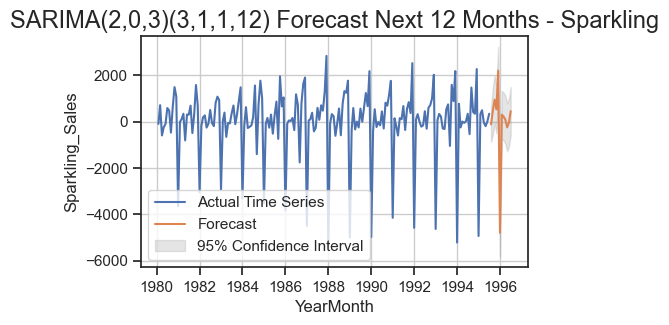

In [158]:
plt.plot(differenced_data, label='Actual Time Series')
plt.plot(pred_full_manual_SARIMA_date['mean'], label='Forecast')
plt.fill_between(pred_full_manual_SARIMA_date.index, pred_full_manual_SARIMA_date['mean_ci_lower'], pred_full_manual_SARIMA_date['mean_ci_upper'], color='gray', alpha=0.2, label='95% Confidence Interval')


plt.xlabel('YearMonth')
plt.ylabel('Sparkling_Sales')
plt.legend(loc='best')
plt.grid();
plt.title('SARIMA(2,0,3)(3,1,1,12) Forecast Next 12 Months - Sparkling', fontsize=17);
figsize=(12, 8)

In [159]:
# Forecasting
forecast_horizon = 12
forecast_sarima = results_full_data_model_sarima.get_forecast(steps=forecast_horizon)

# Confidence Intervals Calculation
pred_sarima_df = pd.DataFrame({
    'lower_CI': forecast_sarima.conf_int().iloc[:, 0],
    'prediction': forecast_sarima.predicted_mean,
    'upper_CI': forecast_sarima.conf_int().iloc[:, 1]
})

# Print the prediction and confidence intervals
print(pred_sarima_df)


               lower_CI   prediction     upper_CI
1995-08-01  -877.856674  -114.471430   648.913814
1995-09-01  -559.459759   468.665841  1496.791442
1995-10-01   -77.464036   951.927145  1981.318326
1995-11-01  -500.188077   529.269585  1558.727247
1995-12-01  1168.128746  2200.048077  3231.967408
1996-01-01 -5823.875389 -4790.202852 -3756.530315
1996-02-01  -732.359689   301.203180  1334.766050
1996-03-01  -813.056169   221.993703  1257.043575
1996-04-01  -946.583003    90.377087  1127.337177
1996-05-01 -1280.749338  -243.722718   793.303901
1996-06-01 -1079.380268   -41.653914   996.072439
1996-07-01  -582.905725   456.574773  1496.055270


In [160]:
pred_sarima_df.to_csv('Sparkling_Prediction_sarima.csv')

## TES ON COMPLETE DATA

In [139]:
model_TES_full = ExponentialSmoothing(df['Sparkling'],trend='additive',seasonal='additive',initialization_method='estimated')
results_full_data_model = model_TES_full.fit()
print(results_full_data_model.params)

{'smoothing_level': 0.07596713146311772, 'smoothing_trend': 0.03256921715086211, 'smoothing_seasonal': 0.37660762886165167, 'damping_trend': nan, 'initial_level': 2356.500087258337, 'initial_trend': -0.8449338106956193, 'initial_seasons': array([-636.25474139, -723.00153617, -398.66964817, -473.45571811,
       -808.43306854, -815.37001157, -384.24814771,   73.00119661,
       -237.46281546,  272.34574748, 1541.39349329, 2590.11477306]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [140]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assuming df['Date'] is your DateTime Index
df.index = pd.to_datetime(df.index)

# Specify seasonal_periods
model_TES_full = ExponentialSmoothing(df['Sparkling'], trend='additive', seasonal='additive', seasonal_periods=12, initialization_method='estimated')
results_full_data_model = model_TES_full.fit()
print(results_full_data_model.params)


{'smoothing_level': 0.07596713146311772, 'smoothing_trend': 0.03256921715086211, 'smoothing_seasonal': 0.37660762886165167, 'damping_trend': nan, 'initial_level': 2356.500087258337, 'initial_trend': -0.8449338106956193, 'initial_seasons': array([-636.25474139, -723.00153617, -398.66964817, -473.45571811,
       -808.43306854, -815.37001157, -384.24814771,   73.00119661,
       -237.46281546,  272.34574748, 1541.39349329, 2590.11477306]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [141]:
TES_predict_full =  results_full_data_model.forecast(steps=12)
TES_predict_full
prediction_1 = TES_predict_full

In [142]:
# Forecasting using this model for the duration of the test set
TES_predict =  results_full_data_model.forecast(len(df))
TES_predict
print('TES RMSE:',mean_squared_error(df.values,TES_predict.values,squared=False))

TES RMSE: 2097.250303485954


In [143]:
pred_1_df = pd.DataFrame({'lower_CI':prediction_1 - 1.96*np.std(results_full_data_model.resid,ddof=1),
                          'prediction':prediction_1,
                          'upper_ci': prediction_1 + 1.96*np.std(results_full_data_model.resid,ddof=1)})
pred_1_df.head()

,lower_CI,prediction,upper_ci
1995-08-01,1159.508682,1877.431801,2595.354921
1995-09-01,1687.362628,2405.285747,3123.208866
1995-10-01,2524.182579,3242.105698,3960.028817
1995-11-01,3204.266404,3922.189524,4640.112643
1995-12-01,5400.579284,6118.502404,6836.425523


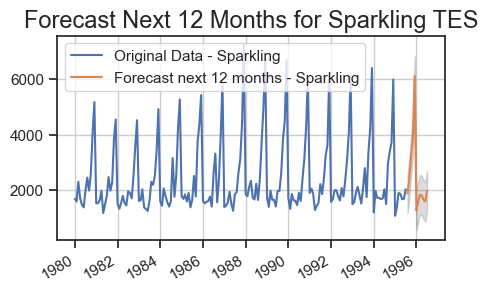

In [144]:
## Plotting the Training data, Test data and the forecasted values

plt.plot(df['Sparkling'], label='Original Data - Sparkling')

ax =TES_predict_full.plot(label='Forecast next 12 months - Sparkling')


ax.fill_between(pred_1_df.index,pred_1_df['lower_CI'], pred_1_df['upper_ci'], color='k', alpha=.15)

plt.legend(loc='best')
plt.grid()
plt.title('Forecast Next 12 Months for Sparkling TES', fontsize=17);



In [161]:
pred_1_df.to_csv('Sparkling_Prediction_TES.csv')